In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
# Make sure to change the path according to your drive.

dataset = '/content/drive/My Drive/Colab/Language Translation/Corpus.csv'
# dataset = '/content/drive/My Drive/Language Translation/Corpus.csv'
df = pd.read_csv(dataset,encoding='utf-8')
df

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
...,...,...,...
127602,indic2012,Examples of art deco construction can be found...,आर्ट डेको शैली के निर्माण मैरीन ड्राइव और ओवल ...
127603,ted,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।
127604,tides,"As for the other derivatives of sulphur , the ...","जहां तक गंधक के अन्य उत्पादों का प्रश्न है , द..."
127605,tides,its complicated functioning is defined thus in...,Zरचना-प्रकिया को उसने एक पहेली में यों बांधा है .


In [ ]:
english_sents = []
english_sents = list(df['english_sentence'])

hindi_sents = []
hindi_sents = list(df['hindi_sentence'])

In [ ]:
# Data cleaning

def eng_data_cleaner(sentence) :

  sentence = sentence.lower()
  sentence = re.sub("[^a-z]+"," ",sentence)
  sentence = sentence.split()
    
  sentence  = [s for s in sentence if len(s)>1]
  sentence = " ".join(sentence)
  return sentence

def hin_data_cleaner(s) :

  # new = re.sub("[\.,|';:@#$%!()*-+`~{}[]=/“”><^_]"," ",s)

  # These are handpicked characters that we have to filter out
  sentence = re.sub("[\८१९५४३७२०६\ंं☻☺♫°º\a-zA-Z\|।.,;:\/?\\<>()*[\]&%$!@#$\'\"0123456789“”_{}\-+=^~`]+",' ',s)
  sentence = sentence.split()
    
  sentence  = [s for s in sentence if len(s)>1]
  sentence = " ".join(sentence)
  return sentence

# Cleaned text ....
cleaned_english = []
cleaned_hindi = []

for i in range(len(english_sents)) :

  # isinstance is a python function, which tells whether an object belongs to a particular class
  # it was used because 2 examples did not contain any english sentence in them
   
  if isinstance(english_sents[i],str) and isinstance(hindi_sents[i],str):

    eng_sent = eng_data_cleaner(english_sents[i])
    hin_sent = hin_data_cleaner(hindi_sents[i])

    if len(eng_sent)<=50 and len(hin_sent)<=48 :

      cleaned_english.append(eng_sent)
      hin_sent = "<start> " + hin_sent + " <end>"
      cleaned_hindi.append(hin_sent)


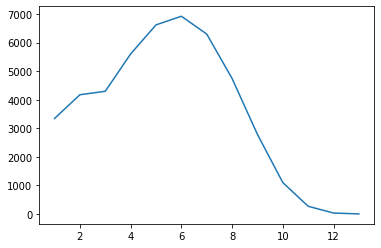

In [ ]:
max = 0   # For calculating max length for english sents
lengths = []  # all lengths .... for frequency of lengths of english sents

for i in cleaned_english :
  length = len(i.split(" "))
  lengths.append(length)

  if length>max :
    max = length
    
lengths_english = np.unique(lengths,return_counts = True)
plt.plot(lengths_english[0],lengths_english[1])

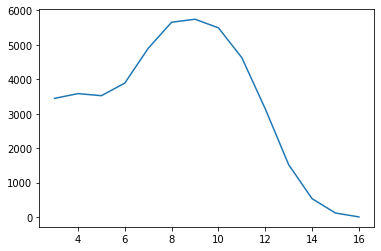

In [ ]:
max = 0   # For calculating max length for hindi sents
lengths = []  # all lengths .... for frequency of lengths of hindi sents

for i in cleaned_hindi :
  length = len(i.split(" "))
  lengths.append(length)

  if length>max :
    max = length
    
lengths_hindi = np.unique(lengths,return_counts = True)
plt.plot(lengths_hindi[0],lengths_hindi[1])

In [ ]:
big_sentence_eng = ''     # One big English sentence
big_sentence_hin = ''     # One big Hindi sentence

for i in range(len(cleaned_english)) : 
  big_sentence_eng += cleaned_english[i] + " "
  big_sentence_hin += cleaned_hindi[i] + " "

eng_words =  big_sentence_eng.split(" ")   # List of all words .... in totallity 
hin_words =  big_sentence_hin.split(" ")

eng_word_freq = np.unique(eng_words,return_counts=True) 
hin_word_freq = np.unique(hin_words,return_counts=True)

In [ ]:
# Freq map of words

eng_words = [w for w in eng_word_freq[0]]
eng_freq = [w for w in eng_word_freq[1]]

hin_words = [w for w in hin_word_freq[0]]
hin_freq = [w for w in hin_word_freq[1]]

eng_word_freq = [(eng_words[i],eng_freq[i]) for i in range(len(eng_words))]
hin_word_freq = [(hin_words[i],hin_freq[i]) for i in range(len(hin_words))]

In [ ]:
eng_word_freq = sorted(eng_word_freq, key = lambda x: x[1])
hin_word_freq = sorted(hin_word_freq, key = lambda x: x[1])

In [ ]:
eng_word_freq.reverse()   # Both the lists in decreasing order
hin_word_freq.reverse()

In [ ]:
# Converting to text file

englishTxt = ""
hindiTxt = ""

for i in eng_word_freq: 
  englishTxt += str(i[1]) + '\t' + str(i[0]) + '\n'

for i in hin_word_freq: 
  hindiTxt += str(i[1]) + '\t' + str(i[0]) + '\n'

In [ ]:
with open('/content/drive/My Drive/Colab/Language Translation/EngFreq.txt','w') as f:
  f.write(englishTxt)

with open('/content/drive/My Drive/Colab/Language Translation/HinFreq.txt','w') as f:
  f.write(hindiTxt)

In [ ]:
# Final Cleaning
# Word frequency threshold : 8 for Hindi

hin_word_freq = dict(hin_word_freq)
eng_word_freq = dict(eng_word_freq)

for i in range(len(cleaned_hindi)) :

  final = ""
  all_words = cleaned_hindi[i].split(" ")
  
  for words in all_words : 
    if hin_word_freq[words]>4 :
      final+= words + " "

  cleaned_hindi[i] = final 

In [ ]:
# Final Bag of Words

english_vocab = set({})

for ix in cleaned_english:
  english_vocab.update(ix.split(" "))

hindi_vocab = set({})

for ix in cleaned_hindi :
  hindi_vocab.update(ix.split(" "))

it = 1

english_bow = {}
hindi_bow = {}
reverse_dict_hin = {}

for i in english_vocab :

  english_bow[i] = it
  it += 1

it = 1 

for i in hindi_vocab:

  hindi_bow[i] = it
  reverse_dict_hin[it] = i
  it += 1

In [ ]:
print(len(hindi_bow),len(english_bow))

4980 18850


In [ ]:
glove_embeddings = {}

glove_txt = ""
with open('/content/drive/My Drive/Colab/Language Translation/glove.txt','r') as f :
# with open('/content/drive/My Drive/Language Translation/glove.txt','r') as f :
  glove_txt = f.read()

In [ ]:
for word_Vecs in glove_txt.split('\n') :
  glove_embeddings[word_Vecs.split(" ")[0]] = np.array(word_Vecs.split(" ")[1:])

In [ ]:
words_not_present = []      # To remove words not present in GLoVE vectors.

for key in english_bow.keys() :
                                                    
  if key not in glove_embeddings.keys() :       
    words_not_present.append(key)

In [ ]:
eng_train, eng_val, hin_train, hin_val = train_test_split(cleaned_english, cleaned_hindi, test_size=0.07, random_state=42)

In [ ]:
len(eng_train)

42975

In [ ]:
def Train_Generator(batch_size) :

  i = 0
  n = len(eng_train)
  english_input = []
  hindi_input = []
  output = []
  cnt = 0

  while True :

    i%= n
    seq = [glove_embeddings[word] for word in eng_train[i].split() if word not in words_not_present]
    while len(seq)<50 :
      seq.append(np.zeros(50,))

    seq = np.array(seq) 

    hin_seq = [hindi_bow[word] for word in hin_train[i].split()]

    ip = []

    for ix in range(1,len(hin_seq)):

      hindi_part = np.zeros((50,))
      pred = np.zeros((len(hindi_bow),))

      for jx in range(ix):
        hindi_part[jx] = hin_seq[jx]
        
      pred[hin_seq[ix]-1] = 1
      # print(hindi_part.shape)

      english_input.append(seq)
      hindi_input.append(hindi_part)
      output.append(pred)

    i+=1
    cnt+=1

    if cnt > batch_size :
      # print(np.array(english_input).shape,np.array(hindi_input).shape)
      yield [ np.array(english_input), np.array(hindi_input)], np.array(output)
      english_input ,hindi_input ,output = [], [], [] 
      cnt = 0

In [ ]:
def Val_Generator(batch_size) :

  i = 0
  n = len(eng_val)
  english_input = []
  hindi_input = []
  output = []
  cnt = 0

  while True :

    i%= n
    seq = [glove_embeddings[word] for word in eng_val[i].split() if word not in words_not_present]
    while len(seq)<50 :
      seq.append(np.zeros(50,))

    seq = np.array(seq) 

    hin_seq = [hindi_bow[word] for word in hin_val[i].split()]

    ip = []

    for ix in range(1,len(hin_seq)):

      hindi_part = np.zeros((50,))
      pred = np.zeros((len(hindi_bow),))

      for jx in range(ix):
        hindi_part[jx] = hin_seq[jx]
        
      pred[hin_seq[ix]-1] = 1
      # print(hindi_part.shape)

      english_input.append(seq)
      hindi_input.append(hindi_part)
      output.append(pred)

    i+=1
    cnt+=1

    if cnt > batch_size :
      # prin(np.array(english_input).shape,np.array(hindi_input).shape)
      yield [np.array(english_input), np.array(hindi_input)], np.array(output)
      english_input ,hindi_input ,output = [], [], [] 
      cnt = 0

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# tf.enable_eager_execution()
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.advanced_activations import LeakyReLU

In [ ]:
eng_context = Sequential()
eng_context.add(Input(shape = (50,50)))
eng_context.add(Bidirectional(LSTM(128)))
eng_context.add(LeakyReLU(0.3))
eng_context.add(Dropout(0.4))
eng_context.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               183296    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
Total params: 183,296
Trainable params: 183,296
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Adding input_length=50 in Embedding layer resolved this array broadcasting problem before, but now it has no effect
# Maybe you can try it after doing some changes

hin_context =  Sequential()

hin_context.add(Input(shape = (50,)))
hin_context.add(Embedding(input_dim=len(hindi_bow)+1,output_dim=50,mask_zero=True)) 
hin_context.add(Bidirectional(LSTM(128)))
eng_context.add(LeakyReLU(0.3))
hin_context.add(Dropout(0.4))
hin_context.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            249050    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               183296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
Total params: 432,346
Trainable params: 432,346
Non-trainable params: 0
_________________________________________________________________


In [ ]:
translator_input = Concatenate()([eng_context.output,hin_context.output])

dense = Dense(256,activation = 'relu')(translator_input)
dropt = Dropout(0.3)(dense)
dense2 = Dense(128,activation = 'relu')(dropt)
translator_output = Dense(len(hindi_bow),activation='softmax')(dense2)

translator = Model(inputs=[eng_context.inputs,hin_context.inputs],outputs=translator_output)
translator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          183296      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256)          0           bidirectional[0][0]              
_______________________________________________________________________________________

In [ ]:
translator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
translator = load_model("/content/drive/My Drive/Colab/Language Translation/best_model_2")
# translator = load_model("/content/drive/My Drive/Language Translation/best_model_2.h5")
translator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 50, 50)]     0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 50, 50)       153900      input_13[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 256)          314368      input_12[0][0]                   
_______________________________________________________________________________________

In [ ]:
modelcheckpoint = ModelCheckpoint("/content/drive/My Drive/Colab/Language Translation/best_model_1", monitor="val_accuracy", verbose=1, save_best_only=True)
# modelcheckpoint = ModelCheckpoint("/content/drive/My Drive/Language Translation/best_model_2.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
# early_stop = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=50, verbose=1, restore_best_weights=True)
CallBks= [modelcheckpoint]

In [ ]:
mytraingen = Train_Generator(128)
myvalgen = Val_Generator(128)

translator.fit(mytraingen,epochs = 50,steps_per_epoch = len(eng_train)//128, validation_data=myvalgen,validation_steps=len(eng_val)//128,callbacks=CallBks)

Epoch 1/50
335/335 [==============================] - ETA: 0s - batch: 167.0000 - size: 836.0000 - loss: 5.8575 - accuracy: 0.1618WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_accuracy improved from -inf to 0.17222, saving model to /content/drive/My Drive/Colab/Language Translation/best_model_1
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab/Language Translation/best_model_1/assets
335/335 [==============================] - 424s 1s/step - batch: 167.0000 - size: 836.0000 - loss: 5.8575 - accuracy: 0.1618 - val_loss: 5.4323 - val_accuracy: 0.1722
Epoch 2/50
335/335 [==============================] - ETA: 0s - batch: 167.0000 - size: 836.2000 - loss: 

In [ ]:
translator.save_weights("/content/drive/My Drive/Colab/Language Translation/best_weights_2.h5")
# translator.save("/content/drive/My Drive/Colab/Language Translation/best_model.h5")

In [ ]:
epochs = 50
batch = 128

for i in range(epochs) :
  
  train_gen = Train_Generator(batch_size=batch)
  val_gen = Val_Generator(batch_size=batch)

  steps_per_epoch = len(cleaned_english)//batch

  for steps in range(steps_per_epoch) :
    temp = next(train_gen)
    input = temp[0]
    output = temp[1]
    translator.fit(input,output)

  print(i+1," Epoch completed \n")

  temp = next(val_gen)
  input = temp[0]
  output = temp[1]
  translator.evaluate(input,output)
#   translator.save("/content/drive/My Drive/Colab/Language Translation/best_model.h5")
#   translator.save_weights("/content/drive/My Drive/Colab/Language Translation/best_weights.h5")

In [ ]:
def Prediction(eng_text) :

  seq = [glove_embeddings[word] for word in eng_text.split() if word not in words_not_present]
  while len(seq)<50 :
    seq.append(np.zeros(50,))

  seq = np.array(seq)   
  seq = np.reshape(seq,(1,50,50))

  it = 1
  hindi_ip = np.zeros((1,50))
  hindi_ip[0][0] = hindi_bow["<start>"]-1

  op = []
  
  temp = translator.predict([seq,hindi_ip])
  pred = np.argmax(temp)

  while it<50 and reverse_dict_hin[pred+1] != "<end>" :
    
    hindi_ip[0][it] = pred
    op.append(reverse_dict_hin[pred+1])
    it += 1

    temp = translator.predict([seq,hindi_ip])
    pred = np.argmax(temp)

  return op

In [ ]:
op = Prediction("the boy")

In [ ]:
print(" ".join(op))

In [ ]:
sample = "this is a cat"

seq = [glove_embeddings[word] for word in sample.split() if word not in words_not_present]

while len(seq)<50 :
  seq.append(np.zeros(50,))

seq = np.array(seq)  
seq = np.reshape(seq,(1,50,50))

hindi_ip = np.zeros((1,50))
hindi_ip[0][0] = hindi_bow["<start>"]

op = translator.predict([seq,hindi_ip])


In [ ]:
pred = reverse_dict_hin[np.argmax(op)+1]
print(pred)

यह


**Storing Files (Not important)**

In [ ]:
# Vocab To text file .... 

with open('/content/drive/My Drive/Colab/Language Translation/english_words.txt','w') as f:
  f.write(str(english_vocab))

with open('/content/drive/My Drive/Colab/Language Translation/hindi_words.txt','w') as f:
  f.write(str(hindi_vocab))

In [ ]:
type(glove_embeddings['and'])

numpy.ndarray

**TRASH/ Debug Code**

In [ ]:
for i in range(len(cleaned_english)) :

  seq = [glove_embeddings[word] for word in cleaned_english[i].split() if word not in words_not_present]
  
  while len(seq)<50 :
    seq.append(np.zeros(50,))

  cleaned_english[i] = np.array(seq) 


for i in range(len(cleaned_hindi)) :

  seq = [hindi_bow[word] for word in cleaned_hindi[i].split()]
  temp = pad_sequences(seq, maxlen = 50, padding="post", value = 0)
  temp = [to_categorical(idx, num_classes = len(hindi_bow)) for idx in temp]
  cleaned_hindi[i] = np.array(temp) 

In [ ]:
ip = []

seq = [glove_embeddings[word] for word in cleaned_english[0].split() if word not in words_not_present]
while len(seq)<50 :
  seq.append(np.zeros(50,))

seq = np.array(seq)
ip.append(seq)
ip.append(seq)

In [ ]:
seq.shape

(50, 50)

In [ ]:
ip.shape

(2, 50, 50)

In [ ]:
len(hindi_bow)

4082

In [ ]:
hindi_bow.items()

dict_items([('', 1), ('तरिक', 2), ('सुनी', 3), ('उत्पादन', 4), ('चुके', 5), ('जैसलमेर', 6), ('हुये', 7), ('दक्षिण', 8), ('हर', 9), ('रोबोट्स', 10), ('सदी', 11), ('गीन', 12), ('नामकरण', 13), ('सल्ल', 14), ('आर', 15), ('बदलते', 16), ('डिजाइन', 17), ('वेदनशील', 18), ('खेलना', 19), ('लेकिन', 20), ('खर्चा', 21), ('दिलाने', 22), ('मेक्सिको', 23), ('हैदराबादी', 24), ('क्षी', 25), ('दीवार', 26), ('माइक्रोसाफ्ट', 27), ('बातो', 28), ('राष्ट्रपति', 29), ('घटक', 30), ('डो', 31), ('कार्रवाई', 32), ('चा', 33), ('जिन्हो', 34), ('तिकारी', 35), ('चिट्ठा', 36), ('बनाने', 37), ('बिस्तर', 38), ('पी', 39), ('कार्ड', 40), ('खाने', 41), ('प्रेरित', 42), ('नौकरी', 43), ('असलियत', 44), ('लगातार', 45), ('कुरु', 46), ('जैसी', 47), ('कृतियाँ', 48), ('दरूनी', 49), ('पशुओ', 50), ('देह', 51), ('खिलाफत', 52), ('कल्पना', 53), ('सान', 54), ('अभिव्यक्ति', 55), ('वाह्य', 56), ('अधिका', 57), ('स्त', 58), ('पहुँचती', 59), ('मूल्य', 60), ('ठेलेप्होने', 61), ('प्राचीन', 62), ('कारोबार', 63), ('कैमरा', 64), ('उम', 65), ('त्रो

In [ ]:
len(eng_train)/50

832.48

In [ ]:
len(cleaned_english)

46210

In [ ]:
hi=np.array([np.zeros(50)])

In [ ]:
hi.shape

NameError: ignored